# Prompt Evaluation Meetings
## Overview
- 17.04.2025: Visualization of the error of interesting prompts
- 01.05.2025: Prompt comparison using metrics_results.csv
- 15.05.2025: Distribution analysis of weighted MAE

## Meeting 17.04.2025 —  Visualization of the error of interesting prompts

C:\Users\samar\AppData\Local\Temp\ipykernel_9704\1080062190.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset[label] = df_subset[label].str.replace(r"\\n", "\n", regex=True)


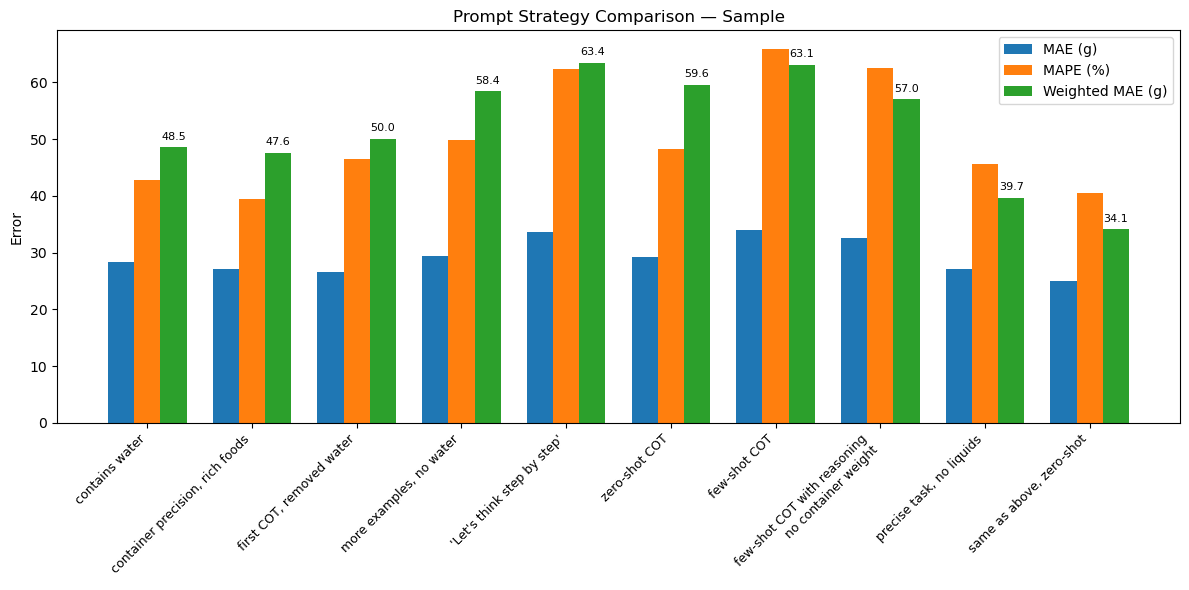

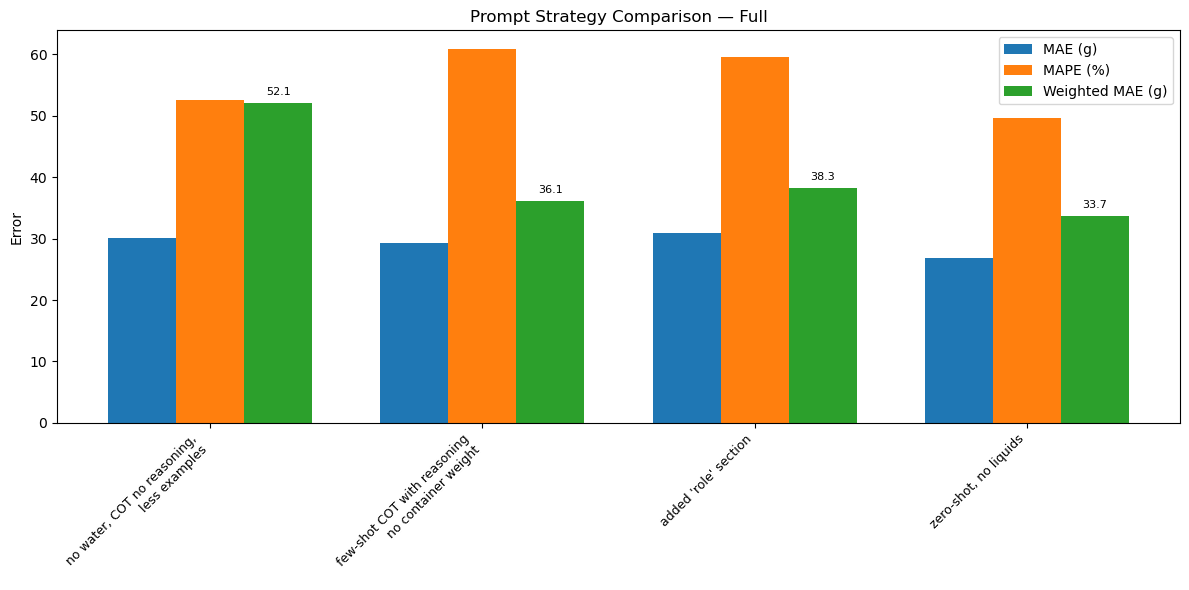

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

# Raw evaluation data (manually entered)
data = [
    ("../data/result/result_7aa63dcf-66f6-4758-b280-5680318bfc29.json", 28.34, 42.87, 48.53, "sample", "contains water"),
    ("../data/result/result_bf71e825-bbae-4e17-a0f4-6d96783d6708.json", 27.18, 39.51, 47.64, "sample", "container precision, rich foods"),
    ("../data/result/result_52a9cff1-1b49-43b9-aa8a-baf2e1016fc9.json", 26.62, 46.56, 50.04, "sample", "first COT, removed water"),
    ("../data/result/result_a97df4c7-2866-4a9f-b673-45bc2488da6e.json", 29.46, 49.76, 58.42, "sample", "more examples, no water"),
    ("../data/result/result_cc37a6b3-b8f6-4e62-b208-e65539a8f94e.json", 33.60, 62.42, 63.42, "sample", "'Let's think step by step'"),
    ("../data/result/result_d27c6de6-cb64-4f00-9ecd-b3cfaf25deee.json", 30.16, 52.60, 52.09, "full", "no water, COT no reasoning,\nless examples"),
    ("../data/result/result_bc3b5069-6b39-4789-984e-fcbffa97a2ae.json", 29.16, 48.22, 59.60, "sample", "zero-shot COT"),
    ("../data/result/result_3282d95c-8a1b-44f5-ad39-7057019c2264.json", 33.97, 65.88, 63.12, "sample", "few-shot COT"),
    ("../data/result/result_17ab87b1-5fab-438e-8325-712a0adf425a.json", 32.59, 62.47, 57.01, "sample", "few-shot COT with reasoning\nno container weight"),
    ("../data/result/result_d392ac97-00d5-4499-9420-f57494015c25.json", 29.27, 60.89, 36.10, "full", "few-shot COT with reasoning\nno container weight"),
    ("../data/result/result_1ab7b2ad-b2a6-4608-81d6-cebcca796fc2.json", 30.95, 59.58, 38.28, "full", "added 'role' section"),
    ("../data/result/result_28454b6a-2c2b-4183-ba36-a815d4a9e888.json", 27.10, 45.57, 39.71, "sample", "precise task, no liquids"),
    ("../data/result/result_b28d51e3-4961-4555-a305-4ee7ba35f137.json", 24.97, 40.56, 34.10, "sample", "same as above, zero-shot"),
    ("../data/result/result_a5d2269f-440b-4759-9bcf-3dba93d9c9e2.json", 26.82, 49.69, 33.71, "full", "zero-shot, no liquids"),
]
columns = ["file", "MAE", "MAPE", "Weighted_MAE", "type", "plot_desc"]
df = pd.DataFrame(data, columns=columns)
df_sample = df[df["type"] == "sample"]
df_full = df[df["type"] == "full"]


# Plotting function
def plot_metrics(df_subset, title, color="black", label="plot_desc", legend_pos='best', save=False):
    df_subset[label] = df_subset[label].str.replace(r"\\n", "\n", regex=True)

    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.25
    x = range(len(df_subset))

    ax.bar([i - bar_width for i in x], df_subset["MAE"], width=bar_width, label="MAE (g)")
    ax.bar(x, df_subset["MAPE"], width=bar_width, label="MAPE (%)")
    bars = ax.bar([i + bar_width for i in x], df_subset["Weighted_MAE"], width=bar_width, label="Weighted MAE (g)")

    # Add labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{height:.1f}", ha='center', va='bottom', fontsize=8)

    ax.set_xticks(x)
    ax.set_xticklabels(df_subset[label], rotation=45, ha="right", fontsize=9, color=color)
    ax.set_ylabel("Error")
    ax.set_title(title)
    ax.legend(loc=legend_pos)
    plt.tight_layout()
    if save:
        title = title.lower()
        title = re.sub(r"[ \-—]+", "_", title)
        title = re.sub(r"[^\w_]", "", title)
        title = title.rstrip("_")
        plt.savefig(f"./outputs/{title}.png")
    plt.show()

plot_metrics(df_sample, "Prompt Strategy Comparison — Sample")
plot_metrics(df_full, "Prompt Strategy Comparison — Full")


## Meeting 01.05.2025 — Prompt comparison from CSV

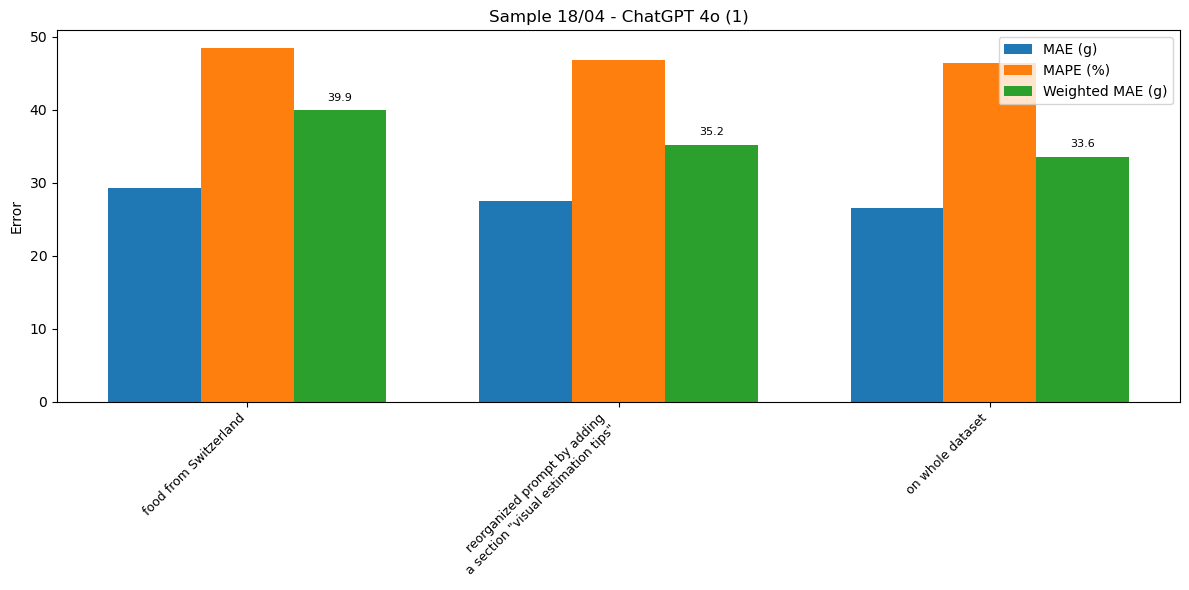

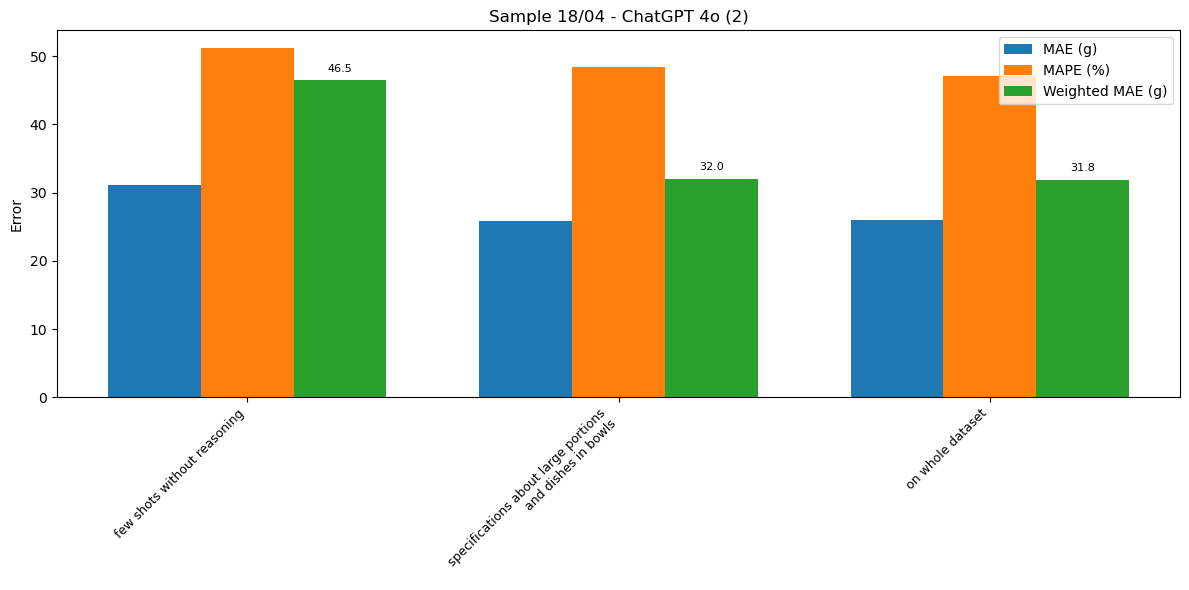

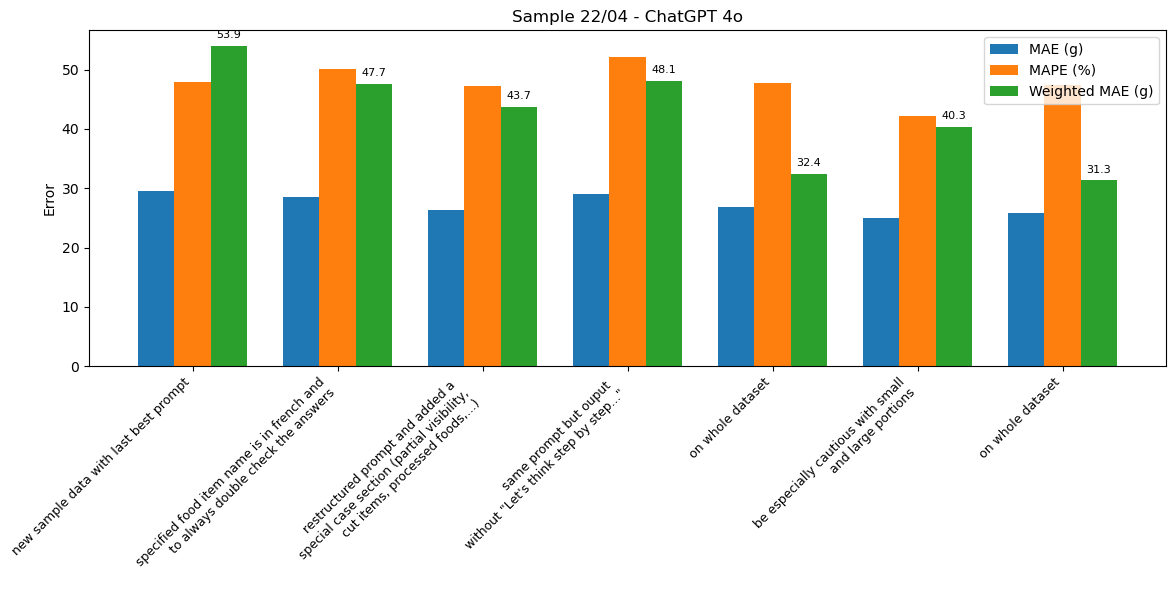

In [2]:
df_metrics = pd.read_csv("./metrics_results.csv")

plot_metrics(df_metrics.iloc[[25, 27, 28]].copy(), "Sample 18/04 - ChatGPT 4o (1)")
plot_metrics(df_metrics.iloc[[30, 33, 34]].copy(), "Sample 18/04 - ChatGPT 4o (2)")
plot_metrics(df_metrics.iloc[[38, 39, 43, 44, 46, 48, 50]].copy(), "Sample 22/04 - ChatGPT 4o")

## Meeting 15.05.2025 — Error distribution analysis

45.41% of dishes account for 80% of the total Weighted MAE.
22.63% of food items account for 80% of total Weighted MAE.


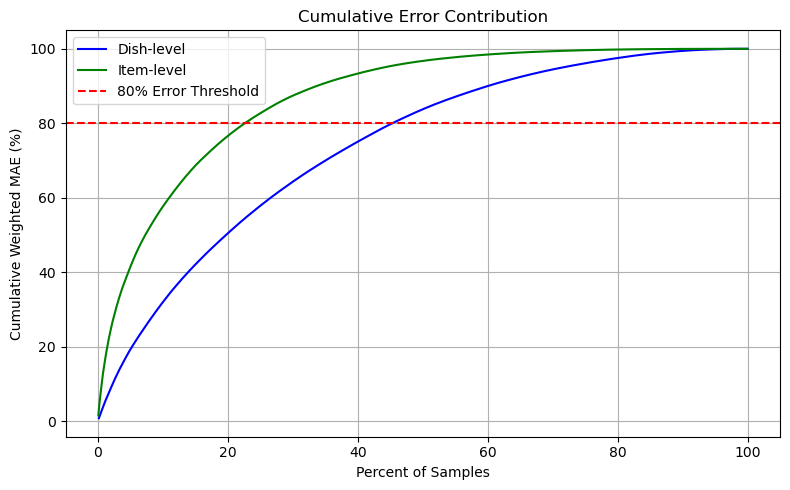

In [3]:
def prepare_df(filename):
    df_error = pd.read_csv(f"../data/comparison/{filename}")

    # Replace empty strings with NaN and drop incomplete rows (e.g. for mismatched rows)
    df_error.replace("", np.nan, inplace=True)
    df_error.dropna(subset=["absolute_error", "weight", "weighed_absolute_error"], inplace=True)


    return df_error.astype({
        "absolute_error": float,
        "weight": float,
        "weighed_absolute_error": float
    })

def per_dish_cum_error(df_error, file): 
    # Keep only one row per image_id (since total_dish_wmae is already summed per dish)
    df_unique = df_error.drop_duplicates(subset=["url"])
    # Sort by error
    df_sorted = df_unique.sort_values("total_dish_wmae", ascending=False) # Already sorted but keep this for safety

    # Compute cumulative error contribution
    total_error = df_sorted["total_dish_wmae"].sum()
    df_sorted["cumulative_error"] = df_sorted["total_dish_wmae"].cumsum()
    df_sorted["fraction_of_total_error"] = 100 * df_sorted["cumulative_error"] / total_error
    df_sorted["fraction_of_dishes"] = 100 * (np.arange(len(df_sorted)) + 1) / len(df_sorted)

    # Find the point where 80% of the error is reached
    threshold_row = df_sorted[df_sorted["fraction_of_total_error"] >= 80].iloc[0]
    fraction_of_dishes_for_80 = threshold_row["fraction_of_dishes"]
    print(f"{fraction_of_dishes_for_80:.2f}% of dishes account for 80% of the total Weighted MAE.")

    df_sorted[df_sorted["fraction_of_total_error"] <= 80].to_csv(f"./outputs/{file}", index=False)
    return df_sorted

def per_food_item_cum_error(df_error, file):
    df_items_sorted = df_error.sort_values("weighed_absolute_error", ascending=False).reset_index(drop=True)
    total_item_error = df_items_sorted["weighed_absolute_error"].sum()

    df_items_sorted["cumulative_error"] = df_items_sorted["weighed_absolute_error"].cumsum()
    df_items_sorted["fraction_of_total_error"] = 100 * df_items_sorted["cumulative_error"] / total_item_error
    df_items_sorted["fraction_of_items"] = 100 * (df_items_sorted.index + 1) / len(df_items_sorted)

    item_threshold = df_items_sorted[df_items_sorted["fraction_of_total_error"] >= 80].iloc[0]
    print(f"{item_threshold['fraction_of_items']:.2f}% of food items account for 80% of total Weighted MAE.")
    df_items_sorted[df_items_sorted["fraction_of_total_error"] <= 80].to_csv(f"./outputs/{file}", index=False)
    return df_items_sorted

def plot_cum_error(df_dish, df_items, fig_name):
    # Cumulative error contribution plot
    plt.figure(figsize=(8, 5))
    plt.plot(df_dish["fraction_of_dishes"], df_dish["fraction_of_total_error"], label="Dish-level", color="blue")
    plt.plot(df_items["fraction_of_items"], df_items["fraction_of_total_error"], label="Item-level", color="green")
    plt.axhline(80, color="red", linestyle="--", label="80% Error Threshold")
    plt.xlabel("Percent of Samples")
    plt.ylabel("Cumulative Weighted MAE (%)")
    plt.title("Cumulative Error Contribution")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"./outputs/{fig_name}")
    plt.show()

def analyze_and_plot(error_file, dish_outfile, item_outfile, fig_name):
    df = prepare_df(error_file)
    df_sorted = per_dish_cum_error(df, dish_outfile)
    df_items_sorted = per_food_item_cum_error(df, item_outfile)
    plot_cum_error(df_sorted, df_items_sorted, fig_name)


# Distribution of the error of the best performing prompt on whole dataset
error_file = "sorted_result_d19c3270-5f4c-4cfb-9e21-8d7e14ece178.csv"

analyze_and_plot(error_file, "top_80_percent_error_0515.csv", "top_80_percent_items_error_0515.csv", "cum_error_0515.png")

## Meeting 15.05.2025 — Additional comparisons (same prompt different models)

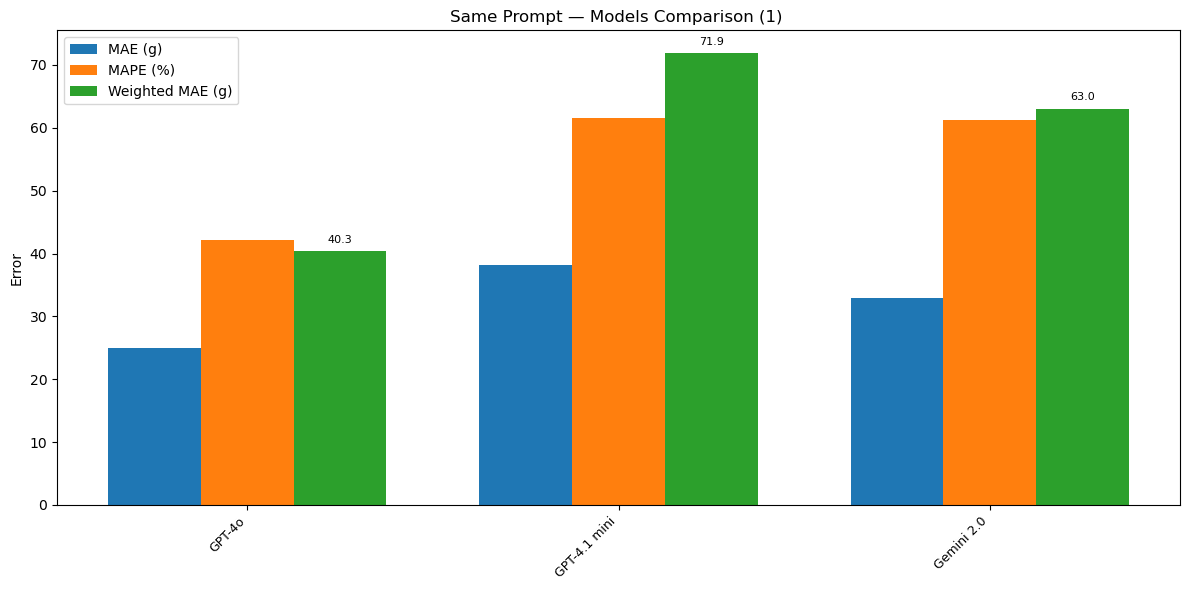

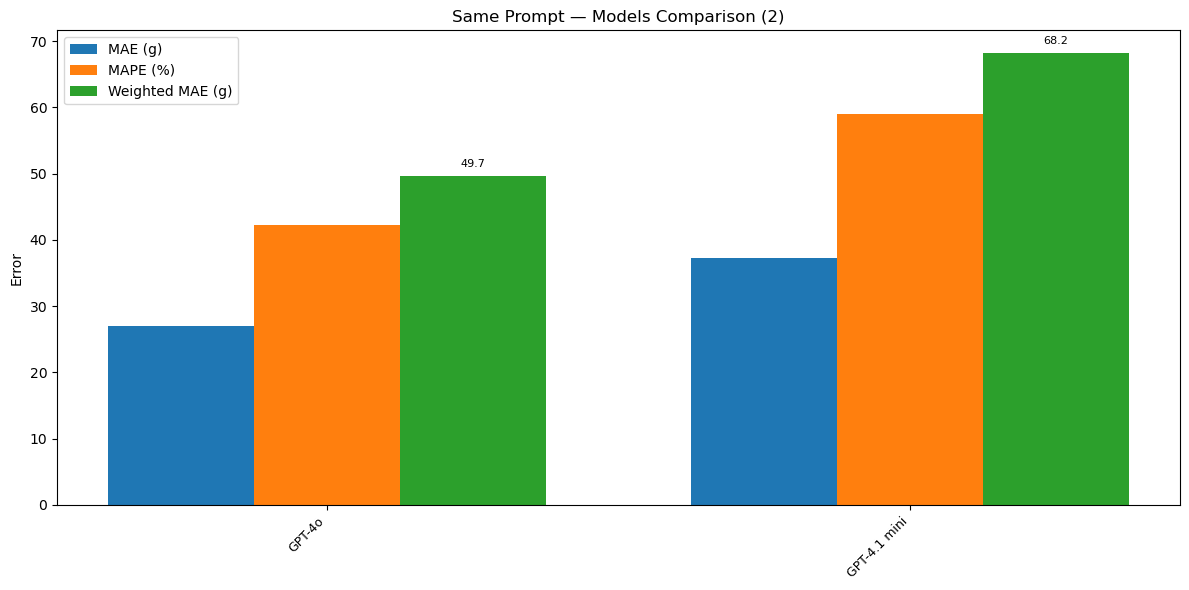

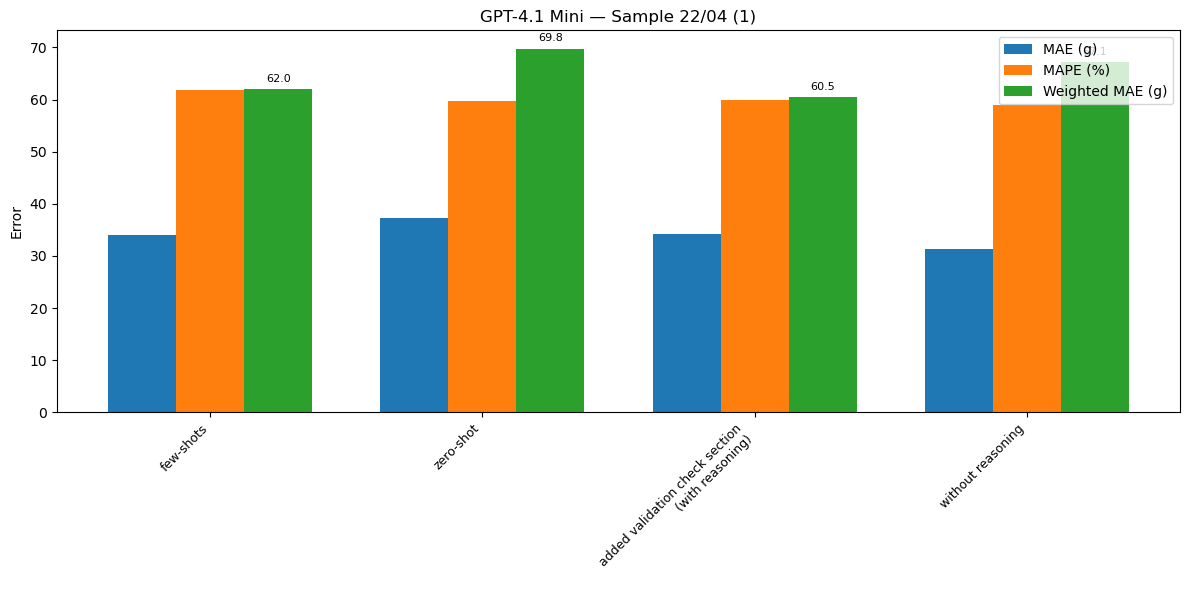

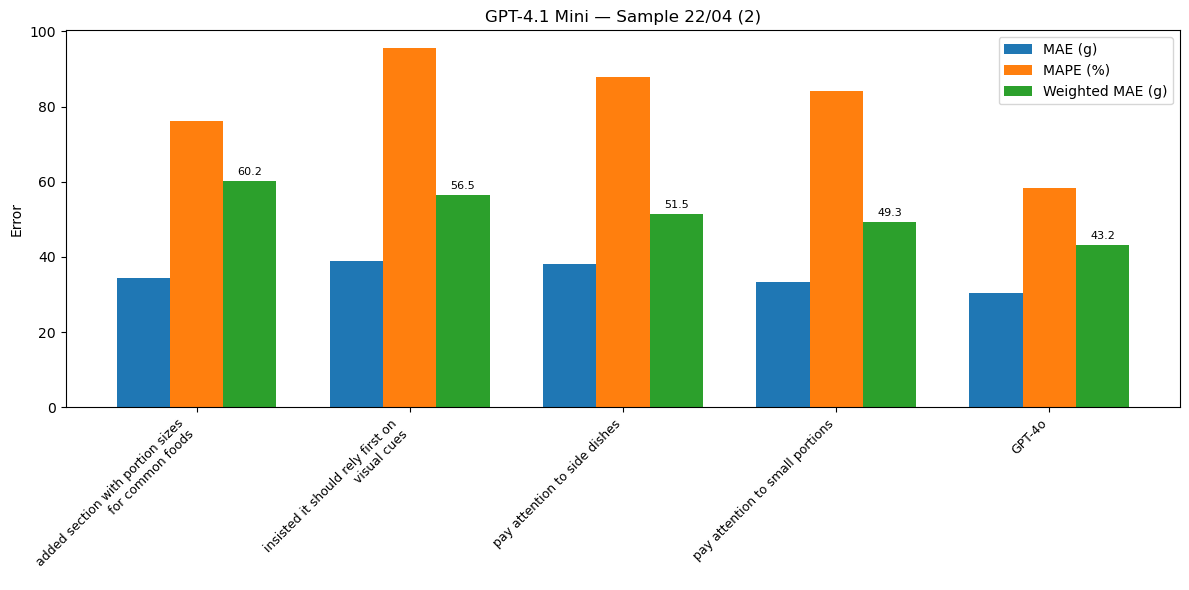

In [4]:
plot_metrics(df_metrics.iloc[[48, 66, 69]].copy(), "Same Prompt — Models Comparison (1) ", label="model", legend_pos='upper left', save=True)
plot_metrics(df_metrics.iloc[[68, 67]].copy(), "Same Prompt — Models Comparison (2)", label="model")
plot_metrics(df_metrics.iloc[[70, 71, 73, 74]].copy(), "GPT-4.1 Mini — Sample 22/04 (1)")
plot_metrics(df_metrics.iloc[[79, 81, 82, 83, 84]].copy(), "GPT-4.1 Mini — Sample 22/04 (2)")


# Additional comparisons


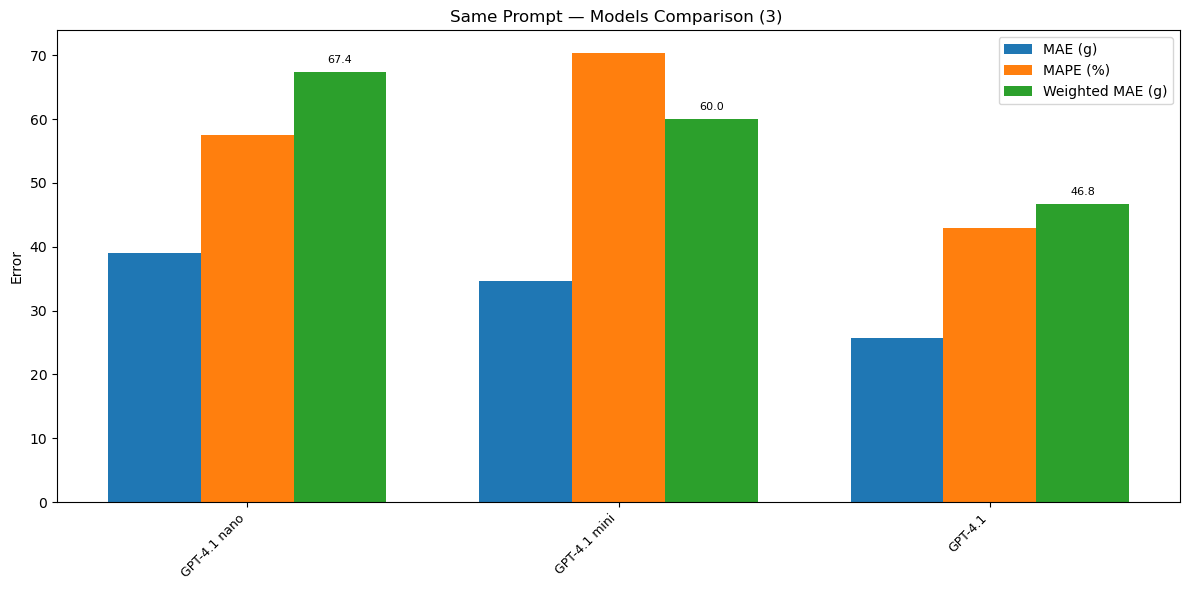

In [5]:
plot_metrics(df_metrics.iloc[[85, 87, 86]].copy(), "Same Prompt — Models Comparison (3) ", label="model", save=True)

# Additional error analysis

44.63% of dishes account for 80% of the total Weighted MAE.
20.29% of food items account for 80% of total Weighted MAE.


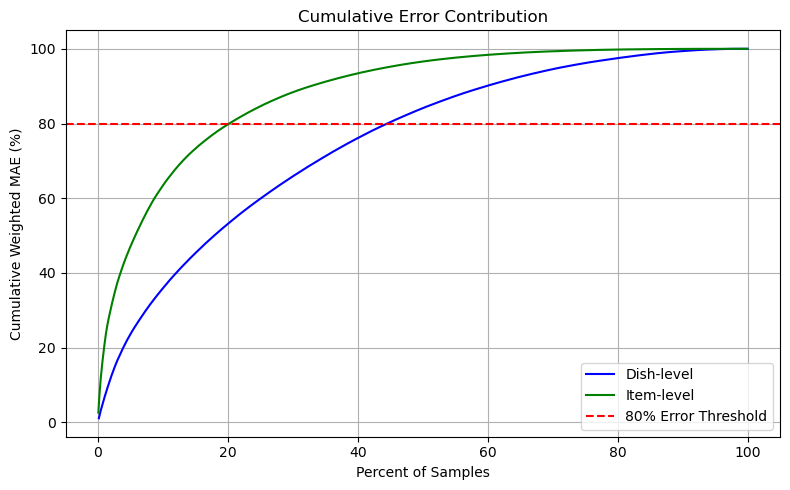

In [6]:
error_f = "sorted_result_f7409570-4c5b-4cc7-b8b1-cf4a80d1010e.csv"

analyze_and_plot(error_f, "top_80_percent_error_0522.csv", "top_80_percent_items_error_0522.csv", "cum_error_0522.png")